# Deklaracja liczb dualnych (wykład)

In [1]:
#typ parametryczny liczby dualnej T # Zdefiniowanie struktury
struct Dual{T <:Number} <:Number
     v::T
    dv::T
end
# Przeciążenie podstawowych operatorów
import Base: +, -, *, /
-(x::Dual)          = Dual(-x.v,       -x.dv)
+(x::Dual, y::Dual) = Dual( x.v + y.v,  x.dv + y.dv)
-(x::Dual, y::Dual) = Dual( x.v - y.v,  x.dv - y.dv)
*(x::Dual, y::Dual) = Dual( x.v * y.v,  x.dv * y.v + x.v * y.dv)
/(x::Dual, y::Dual) = Dual( x.v / y.v, (x.dv * y.v - x.v * y.dv)/y.v^2)
# Przeciążenie podstawowych funkcji
import Base: abs, sin, cos, tan, exp, sqrt, isless
abs(x::Dual)  = Dual(abs(x.v),sign(x.v)*x.dv)
sin(x::Dual)  = Dual(sin(x.v), cos(x.v)*x.dv)
cos(x::Dual)  = Dual(cos(x.v),-sin(x.v)*x.dv)
tan(x::Dual)  = Dual(tan(x.v), one(x.v)*x.dv + tan(x.v)^2*x.dv)
exp(x::Dual)  = Dual(exp(x.v), exp(x.v)*x.dv)
sqrt(x::Dual) = Dual(sqrt(x.v),.5/sqrt(x.v) * x.dv)
isless(x::Dual, y::Dual) = x.v < y.v;
# Pomocne funkcje
import Base: show
show(io::IO, x::Dual) = print(io, "(", x.v, ") + [", x.dv, "ϵ]");
value(x::Dual) = x.v;
partials(x::Dual) = x.dv;
# Promocja typów i konwersja
import Base: convert, promote_rule
convert(::Type{Dual{T}}, x::Dual) where T = Dual(convert(T, x.v), convert(T, x.dv))
@show Dual{Float64}[Dual(1,2), Dual(3,0)];
convert(::Type{Dual{T}}, x::Number) where T = Dual(convert(T, x), zero(T))
@show Dual{Float64}[1, 2, 3];
promote_rule(::Type{Dual{T}}, ::Type{R}) where {T,R} = Dual{promote_type(T,R)}
@show Dual(1,2) * 3;



Dual{Float64}[Dual(1, 2), Dual(3, 0)] = Dual{Float64}[(1.0) + [2.0ϵ], (3.0) + [0.0ϵ]]
Dual{Float64}[1, 2, 3] = Dual{Float64}[(1.0) + [0.0ϵ], (2.0) + [0.0ϵ], (3.0) + [0.0ϵ]]
Dual(1, 2) * 3 = (3) + [6ϵ]


In [2]:
import Random: seed!
seed!(5555)

Random.TaskLocalRNG()

# Import iris dataset

In [3]:
using RDatasets

iris = dataset("datasets", "iris")



,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
,Float64,Float64,Float64,Float64,Cat…
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa
7,4.6,3.4,1.4,0.3,setosa
8,5.0,3.4,1.5,0.2,setosa
9,4.4,2.9,1.4,0.2,setosa


In [4]:
input = Matrix(iris[:, 1:4])
output = iris[:,5]

150-element CategoricalArrays.CategoricalArray{String,1,UInt8}:
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 ⋮
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"

# Dzielelnie danych na dwa zestawy w podanej proporcji 4:1

In [5]:
using Random

function randomizeSets(input, output)
    proportion = 0.8
    n = length(output)


    trainNumber = ceil(Int, proportion*n)
    i = randperm(n)
    
    trainData = i[1:trainNumber]
    testData = i[trainNumber+1:end]

    return selectdim(input, 1, trainData), output[trainData], selectdim(input, 1, testData), output[testData]
end

randomizeSets (generic function with 1 method)

In [6]:
trainInputs, trainOutputs, testInputs, testOutputs = randomizeSets(input, output)

([6.7 3.0 5.2 2.3; 6.7 2.5 5.8 1.8; … ; 6.0 2.2 5.0 1.5; 6.1 2.8 4.0 1.3], CategoricalArrays.CategoricalValue{String, UInt8}["virginica", "virginica", "virginica", "versicolor", "virginica", "virginica", "versicolor", "setosa", "setosa", "versicolor"  …  "setosa", "versicolor", "versicolor", "versicolor", "setosa", "setosa", "setosa", "versicolor", "virginica", "versicolor"], [5.6 3.0 4.1 1.3; 5.0 3.0 1.6 0.2; … ; 5.2 3.5 1.5 0.2; 6.4 3.1 5.5 1.8], CategoricalArrays.CategoricalValue{String, UInt8}["versicolor", "setosa", "versicolor", "virginica", "virginica", "setosa", "virginica", "virginica", "setosa", "setosa"  …  "versicolor", "versicolor", "versicolor", "versicolor", "versicolor", "setosa", "setosa", "virginica", "setosa", "virginica"])

# Funkcja zmieniająca nazwy kwiatów na wartości liczbowe np. [0,0,1]

In [7]:
function onehot(data, classes)
    data_onehot = falses(length(classes), length(data))
    for (i, class) in enumerate(classes)
        data_onehot[i, data .== class] .= 1
    end
    return data_onehot
end

onehot (generic function with 1 method)

# Funkcja zmieniająca wartości liczbowe na nazwy kwiatów, największą wartość zamienia na 1, resztę cyfr na 0: np. [0.321, 0.24, -0.1] zamieni na [1,0,0]

In [8]:
onecold(data, classes) = [classes[argmax(data_col)] for data_col in eachcol(data)]

onecold (generic function with 1 method)

In [9]:
classes = unique(trainOutputs)

3-element Vector{String}:
 "virginica"
 "versicolor"
 "setosa"

In [10]:
trainOutputs = onehot(trainOutputs, classes)

3×120 BitMatrix:
 1  1  1  0  1  1  0  0  0  0  1  0  0  …  0  0  0  0  0  0  0  0  0  0  1  0
 0  0  0  1  0  0  1  0  0  1  0  0  1     0  0  0  1  1  1  0  0  0  1  0  1
 0  0  0  0  0  0  0  1  1  0  0  1  0     1  1  1  0  0  0  1  1  1  0  0  0

# Deklaracje z wykładu:

In [11]:
fullyconnected(w::Vector, n::Number, m::Number, v::Vector, activation::Function) = activation.(reshape(w, n, m) * v)
ReLU(x) = max(zero(x), x)
mean_squared_loss(y, ŷ) = sum(0.5(y - ŷ).^2)
σ(x) = one(x) / (one(x) + exp(-x))
linear(x) = x
softmax(x) = exp.(x) ./ sum(exp.(x))


softmax (generic function with 1 method)

# Macierz jacobiego do różniczkowania (wykład)

In [12]:
J = function jacobian(f, args::Vector{T}) where {T <:Number}
    jacobian_columns = Matrix{T}[]
    
    for i=1:length(args)
        x = Dual{T}[]
        for j=1:length(args)
            seed = (i == j)
            push!(x, seed ?
                Dual(args[j], one(args[j])) :
                Dual(args[j],zero(args[j])) )
        end
        column = partials.([f(x)...])
        push!(jacobian_columns, column[:,:])
    end
    hcat(jacobian_columns...)
end

jacobian (generic function with 1 method)

# Specyfiakcja liczby neuronów w jednej, ukrytej warstwie

In [13]:
no_neurons = 20

20

# Losowanie wag

In [14]:
Wh = randn(no_neurons,4)
Wo = randn(3,no_neurons)
dWh = similar(Wh)
dWo = similar(Wo)
E = Float64[]
Accuracy = Float64[]

Float64[]

In [15]:
Wh

20×4 Matrix{Float64}:
 -1.11348     -0.0340311   0.191851    0.723227
 -0.131633    -1.14466    -2.42235     0.741319
  2.16007      0.811691   -0.382707    0.65982
 -0.341519    -0.366238    0.343368    0.0531781
  1.17708      0.845738    1.09125     0.744773
 -0.375181     1.84336    -2.01023     0.295086
  1.29543     -1.33399     1.26236     0.101986
 -1.82203      0.463119    1.65616     2.37932
  0.571623    -1.25315     1.3346     -0.00786125
 -0.00353613   1.04521    -1.09272    -1.19822
  0.763752    -0.210283   -1.00217    -0.0796579
  0.0882155    1.27133    -0.663863   -1.44673
 -0.832174     0.476609   -0.984626   -0.0703005
 -1.22842     -0.928746    2.47547     0.487118
 -0.631503    -0.506011   -0.200663   -0.405165
  1.01953      0.651491    0.143051    1.46121
  0.442197    -0.47723     0.768861   -0.150785
 -1.37122      0.450407    0.0558977   0.929183
 -0.400785    -1.50552     1.58434    -0.400396
  0.271303     0.77162    -1.66481    -0.226923

In [16]:
Wh_n, Wh_m = size(Wh)
Wo_n, Wo_m = size(Wo)

(3, 20)

# sieć (wykład)

In [17]:
function net(x, wh, wo, y)
    x̂ = fullyconnected(wh, no_neurons, 4, x, σ)
    ŷ = fullyconnected(wo, 3, no_neurons, x̂, u->u)
    
    E = mean_squared_loss(y, ŷ)
end


net (generic function with 1 method)

# Nieznacznie zmieniłem wzory z książki: ∇f = dW,  θ = Wx

# Testowałem różne metody optymializacyjne z wykładu, poniżej znajdują się ich deklaracje

# Gradient Descent

In [18]:
abstract type DescentMethod end
struct GradientDescent <: DescentMethod
 α # learning rate
end

function step!(M::GradientDescent, dW, Wx)
 α, g = M.α, dW
 return Wx - α*g
end

opt = GradientDescent(0.1)

GradientDescent(0.1)

# Momentum

In [19]:
mutable struct Momentum <: DescentMethod
 α # learning rate
 β # momentum decay
 v # momentum
 Momentum() = new() # new uninitialized structure
end

function init!(M::Momentum, θ; α=0.01, β=0.5)
 M.α = α
 M.β = β
 M.v = zero(θ)
 return M
end

function step!(M::Momentum, dW, Wx)
 α, β = M.α, M.β
 v, g = M.v, dW
 v[:] = β*v .- α*g
 return Wx + v
end
optMomentumWh = Momentum() # create an uninitialized Momentum optimizer
optMomentumWo = Momentum()

Momentum(#undef, #undef, #undef)

# Adam

In [20]:
mutable struct Adam <: DescentMethod
 α # learning rate
 ε # small value
 v # sum gradient
 s # sum of squared gradient
 γs # gradient decay
 γv # momentum decay
 k # step counter
 Adam() = new() # new uninitialized structure
end

function init!(M::Adam, θ; α=0.001, γv=0.9, γs=0.999, ε=1e-8)
 M.α = α
 M.ε = ε
 M.γs = γs
 M.γv = γv
 M.s = zero(θ)
 M.v = zero(θ)
 M.k = 0
 return M
end

init! (generic function with 2 methods)

In [21]:
function step!(M::Adam, dW, Wx)
 γs, γv = M.γs, M.γv
 α, ε, k = M.α, M.ε, M.k
 s, v, g = M.s, M.v, dW
 v[:] = γv*v + (1.0 - γv) * g
 s[:] = γs*s + (1.0 - γs) * g .* g
 M.k = k += 1
v̂ = v ./ (1.0 - γv^k)
 ŝ = s ./ (1.0 - γs^k)
 return Wx - α*v̂ ./ (sqrt.(ŝ) .+ ε)
end

step! (generic function with 3 methods)

In [22]:
optAdamWh = Adam()
optAdamWo = Adam()

Adam(#undef, #undef, #undef, #undef, #undef, #undef, #undef)

# Adadelta

In [23]:
mutable struct Adadelta <: DescentMethod
 ε # small value
 s # sum of squared gradient
 u # sum of squared update
 γs # gradient decay
 γθ # update decay
 Adadelta() = new() # new uninitialized structure
end
function init!(M::Adadelta, θ; γs=0.9, γθ= 0.5, ε=1e-8)
 M.ε = ε
 M.s = zero(θ)
 M.u = zero(θ)
 M.γs = γs
 return M
end
function step!(M::Adadelta, dW, Wx)
 γs, γθ, ε = M.γs, M.γθ, M.ε
 s, u, g = M.s, M.u, dW
 s[:] = γs*s + (1.0 - γs) * g .* g
 Δθ = - (sqrt.(u) .+ ε) ./ (sqrt.(s) .+ ε) .* g
 u[:] = γθ*u + (1.0 - γθ) * Δθ .* Δθ
 return Wx + Δθ
end
optAdadelta = Adadelta()

Adadelta(#undef, #undef, #undef, #undef, #undef)

# Funkcja testująca dokładność modelu

In [24]:
function getAccuracy()
    match = 0
    for i in 1:length(testInputs[:,1])
        
        x = copy(testInputs[i,:]) 
        x̂ = copy(fullyconnected(Wh[:], no_neurons, 4, x, σ))
        ŷ = copy(fullyconnected(Wo[:], 3, no_neurons, x̂, u->u))

        if onecold(ŷ,classes)[1] == testOutputs[i]
            match += 1
        end 
    end 
    
    return match/length(testInputs[:,1])
end
#     print("Classified as: " )
#     print(onecold(ŷ,classes)[1])
#     print(" ")
    
#     print(testInputs[i,:])
#     print(" correct classification: ")
#     print(testOutputs[i])
 
#     println()


getAccuracy (generic function with 1 method)

# Uczenie sieci nuronowej z optymalizacją Momentum

In [25]:
for i in 1:length(trainInputs[:,1])
        
        x = copy(trainInputs[i,:])
        y = copy(trainOutputs[:,i]) 

        Ei = net(x, Wh[:], Wo[:], y)
        push!(E, Ei)
        acc = getAccuracy()
        push!(Accuracy, acc)
        
            dnet_Wh(x, wh, wo, y) = J(w -> net(x, w, wo, y), wh);
            dnet_Wo(x, wh, wo, y) = J(w -> net(x, wh, w, y), wo);
    
          init!(optMomentumWh, dWh)
          init!(optMomentumWo, dWo)
        
        epchos = 10
        for i=1:epchos
        
            dWh[:] = dnet_Wh(x, Wh[:], Wo[:], y);
            dWo[:] = dnet_Wo(x, Wh[:], Wo[:], y);
        
             Wh = step!(optMomentumWh, dWh, Wh)        
             Wo = step!(optMomentumWo, dWo, Wo)
        
#                       Wh -= 0.1dWh
#                       Wo -= 0.1dWo
        
        end
    
end
            acc = getAccuracy()
            push!(Accuracy, acc)
    
    
    
    

121-element Vector{Float64}:
 0.26666666666666666
 0.26666666666666666
 0.3
 0.26666666666666666
 0.36666666666666664
 0.3
 0.3
 0.4
 0.7333333333333333
 0.7333333333333333
 0.7333333333333333
 0.6333333333333333
 0.9666666666666667
 ⋮
 0.9333333333333333
 0.9333333333333333
 0.9333333333333333
 0.8
 1.0
 0.9666666666666667
 0.9666666666666667
 0.9666666666666667
 0.9666666666666667
 1.0
 0.7666666666666667
 1.0

In [26]:
E

120-element Vector{Float64}:
 8.28425867225273
 0.04429720547794186
 0.07086227134482855
 1.3336709636766781
 0.6483147352982638
 0.030539720122925253
 0.5526828449525641
 0.37120354559159086
 0.10946213144178514
 0.540589145488714
 0.9011654786111382
 0.5426443340964566
 0.21140135185574777
 ⋮
 0.06655171943855986
 0.016988620810659636
 0.05690394990231063
 0.05762292899261505
 0.21322577532213524
 0.006815962986986415
 0.10881243060564183
 0.0028543787428989206
 0.013095031555548343
 0.051359063823469005
 0.13288221847675352
 0.11662620901602157

In [27]:
using PyPlot

# Funkcja straty

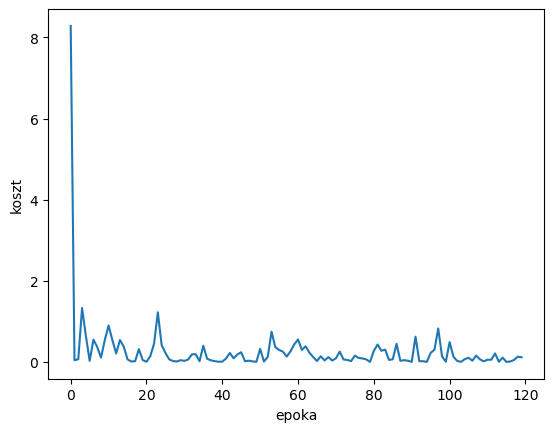

PyObject Text(24.000000000000007, 0.5, 'koszt')

In [28]:
plot(E)
xlabel("epoka")
ylabel("koszt")

# Dokładność modelu

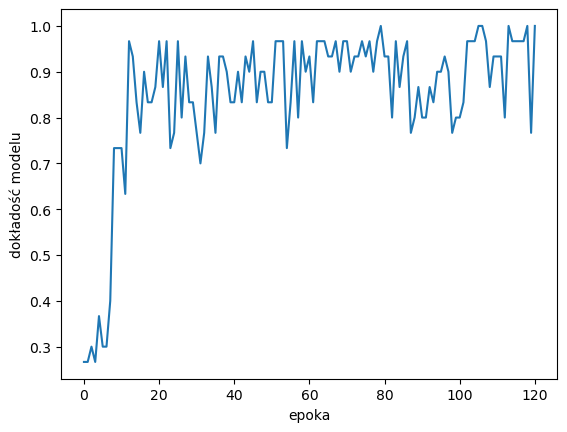

PyObject Text(24.000000000000007, 0.5, 'dokładość modelu')

In [29]:
plot(Accuracy)
xlabel("epoka")
ylabel("dokładość modelu")

# Dokładność modelu

In [30]:
print("Dokładość modelu: ", getAccuracy())

Dokładość modelu: 1.0

# Weryfikacja poprawności wyników

# Losowanie i podział danych dokonane na początku pozwala mi na późniejsze przepuszczenie przez model czterech liczb opisujących kwiaty(testInputs), określenie ich przynależności na podstawie wytrenowanego modelu oraz późniejszą weryfikację na podstawie indeksów w tabeli (TestOutputs)

In [31]:
    for i in 1:length(testInputs[:,1])
        x = copy(testInputs[i,:]) 
        x̂ = copy(fullyconnected(Wh[:], no_neurons, 4, x, σ))
        ŷ = copy(fullyconnected(Wo[:], 3, no_neurons, x̂, u->u))
    
    print("Classified as: " )
    print(onecold(ŷ,classes)[1])
    print(" ")
    
    print(testInputs[i,:])
    print(" correct classification: ")
    print(testOutputs[i])
 
    println()     
     
    end



Classified as: versicolor [5.6, 3.0, 4.1, 1.3] correct classification: versicolor
Classified as: setosa [5.0, 3.0, 1.6, 0.2] correct classification: setosa
Classified as: versicolor [6.3, 2.5, 4.9, 1.5] correct classification: versicolor
Classified as: virginica [7.2, 3.0, 5.8, 1.6] correct classification: virginica
Classified as: virginica [7.4, 2.8, 6.1, 1.9] correct classification: virginica
Classified as: setosa [4.4, 3.2, 1.3, 0.2] correct classification: setosa
Classified as: virginica [7.7, 2.8, 6.7, 2.0] correct classification: virginica
Classified as: virginica [7.6, 3.0, 6.6, 2.1] correct classification: virginica
Classified as: setosa [4.9, 3.1, 1.5, 0.2] correct classification: setosa
Classified as: setosa [5.0, 3.3, 1.4, 0.2] correct classification: setosa
Classified as: virginica [6.4, 2.7, 5.3, 1.9] correct classification: virginica
Classified as: setosa [5.4, 3.9, 1.3, 0.4] correct classification: setosa
Classified as: setosa [5.5, 3.5, 1.3, 0.2] correct classification: